In [1]:
import numpy as np
import pandas as pd
import math
import tqdm
import re
import string
!pip install lightfm
from lightfm import LightFM
from io import BytesIO
from PIL import Image
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import gensim
from scipy.sparse import coo_matrix, csr_matrix, hstack
from scipy.sparse.linalg import svds
from sklearn.neighbors import NearestNeighbors
from sklearn import preprocessing

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
books = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/rec_sys/BX-Books.csv')
interactions = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/rec_sys/BX-Book-Ratings.csv", sep=";", encoding = "ISO-8859-1")
users = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/rec_sys/BX-Users.csv', delimiter=';', encoding = 'ISO-8859-1')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
books.head()

ISBN  ...                                        Image-URL-L
0  0195153448  ...  http://images.amazon.com/images/P/0195153448.0...
1  0002005018  ...  http://images.amazon.com/images/P/0002005018.0...
2  0060973129  ...  http://images.amazon.com/images/P/0060973129.0...
3  0374157065  ...  http://images.amazon.com/images/P/0374157065.0...
4  0393045218  ...  http://images.amazon.com/images/P/0393045218.0...

[5 rows x 8 columns]

In [4]:
interactions.head()

User-ID        ISBN  Book-Rating
0   276725  034545104X            0
1   276726  0155061224            5
2   276727  0446520802            0
3   276729  052165615X            3
4   276729  0521795028            6

In [5]:
users.head()

User-ID                            Location   Age
0        1                  nyc, new york, usa   NaN
1        2           stockton, california, usa  18.0
2        3     moscow, yukon territory, russia   NaN
3        4           porto, v.n.gaia, portugal  17.0
4        5  farnborough, hants, united kingdom   NaN

In [6]:
#Минус нулевой рейтинг
interactions = interactions[interactions["Book-Rating"] != 0]

In [7]:
books_meets = interactions.groupby("ISBN")["User-ID"].count().reset_index().rename(columns={"User-ID": "user_num"})
user_meets = interactions.groupby("User-ID")["ISBN"].count().reset_index().rename(columns={"ISBN": "books_num"})

In [8]:
books_meets.head()

ISBN  user_num
0    0330299891         1
1    0375404120         1
2    9022906116         1
3      #6612432         1
4  '9607092910'         1

In [9]:
user_meets.head()

User-ID  books_num
0        8          7
1        9          1
2       10          1
3       12          1
4       14          3

In [10]:
interactions = interactions.merge(books_meets, on=["ISBN"]).merge(user_meets, on=["User-ID"])
interactions = interactions[(interactions["user_num"] > 5) & 
                            (interactions["books_num"] > 5) &
                            (interactions["books_num"] < 200)]

interactions.head()

User-ID        ISBN  Book-Rating  user_num  books_num
5       86583  3404139178            9         8         18
6       86583  3453061187            8        13         18
13      86583  3426609061            7         8         18
8555    16877  038550120X            9        81         10
8556    16877  034539657X            7        26         10

In [11]:
interactions = interactions.merge(books[["ISBN", "Image-URL-M", "Book-Title"]].rename(
    columns={"Image-URL-M": "picture_url"}), on=["ISBN"])
interactions.head()

User-ID  ...                                   Book-Title
0    86583  ...  Das Lacheln der Fortuna: Historischer Roman
1   132500  ...  Das Lacheln der Fortuna: Historischer Roman
2    66483  ...  Das Lacheln der Fortuna: Historischer Roman
3   276866  ...  Das Lacheln der Fortuna: Historischer Roman
4   106534  ...  Das Lacheln der Fortuna: Historischer Roman

[5 rows x 7 columns]

In [12]:
le = preprocessing.LabelEncoder()
interactions["product_id"] = le.fit_transform(interactions["ISBN"])
interactions["vid"] = le.fit_transform(interactions["User-ID"])
interactions.head()

User-ID        ISBN  ...  product_id    vid
0    86583  3404139178  ...       10397   3445
1   132500  3404139178  ...       10397   5248
2    66483  3404139178  ...       10397   2622
3   276866  3404139178  ...       10397  10887
4   106534  3404139178  ...       10397   4228

[5 rows x 9 columns]

#### 1. Реализовать персональный топ - принимает на вход возраст и локацию, на выходе персональный топ - 1 балл

Топ определяется по средней оценке n ближайших соседей. Признаком определения ближайших соседей является возраст и местоположение пользователя

In [13]:
def print_top_books(rating, id_top, interactions, n_top=10):
    figure = plt.figure(figsize=(20, 10))
    for i, id in enumerate(id_top[:n_top]):
        url = interactions.loc[interactions['product_id'] == id, 'picture_url'].values[0]
        title = interactions.loc[interactions['product_id'] == id, 'Book-Title'].values[0]
        r = requests.get(url)
        image = Image.open(BytesIO(r.content))
        fig = figure.add_subplot(np.round(n_top / 5), 5, i + 1)
        if rating[i] is not None:
          fig.title.set_text(f"{title[:15]}..\nbook_id = {id}\nbook_rating = {rating[i]}")
        plt.imshow(image)
        plt.axis('off')  
    plt.show()

In [14]:
def chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]

def rec_imaging(product_ids, content_dict, measure=None, top_n=5):
    picture_urls = [content_dict[i] for i in product_ids]
    cnt = 0
    for idx, chunk in enumerate(chunks(picture_urls, top_n)):
        fig = plt.figure(figsize=(20, 4))
        for n, i in enumerate(chunk):
            try:
                r = requests.get(i)
                im = Image.open(BytesIO(r.content))

            except:
                print('Something went wrong with {url}'.format(url=i))
                continue

            a = fig.add_subplot(1, top_n, n + 1)
            if measure is not None:
                a.title.set_text("measure = {}".format(np.round(measure[cnt], 4)))
                cnt += 1
            plt.imshow(im)
            plt.axis('off')
        plt.show()

In [15]:
csr_rates = coo_matrix((interactions["Book-Rating"], (interactions["vid"], interactions["product_id"])), 
                            shape=(len(set(interactions["vid"])), len(set(interactions["product_id"]))))
csr_rates.shape

(10960, 10712)

Предобработка

In [16]:
users = users.loc[users['User-ID'].isin(le.classes_)]

Нормализация и заполнение пропусков

In [17]:
users.Age = users.Age.fillna(value=int(users.Age.mean()))
users.Age = (users.Age - users.Age.min()) / (users.Age.max() - users.Age.min())

In [18]:
tf_idf = TfidfVectorizer(analyzer='word', ngram_range=(1, 1), binary=True, min_df=3)
vec = tf_idf.fit_transform(users.Location.values)

In [19]:
users = users.reset_index(drop=True)
tf_idf_df = pd.DataFrame(vec.toarray(), columns=tf_idf.get_feature_names())
prep_users = pd.concat([users, tf_idf_df], axis=1).drop(['Location', 'User-ID'], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  "X does not have valid feature names, but"


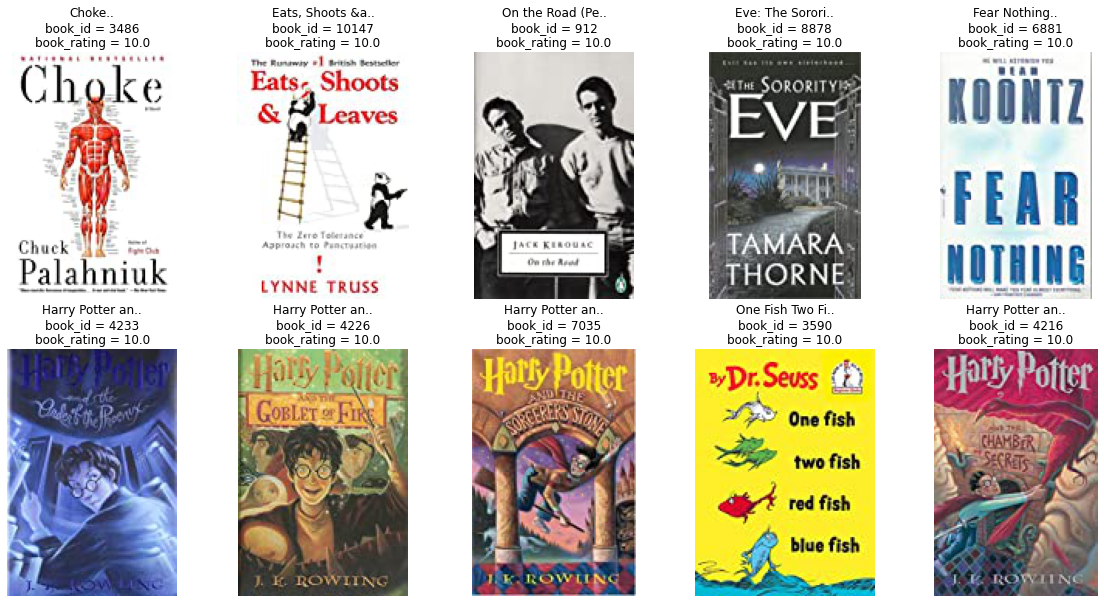

In [20]:
nearNeighb = NearestNeighbors(n_neighbors=180).fit(prep_users)
ind = nearNeighb.kneighbors([prep_users.iloc[123]], return_distance=False);

#Определяем средний рейтинг
ratings = np.zeros(csr_rates.shape[1])
count = np.zeros(csr_rates.shape[1])
  
for i in ind[0]:
    ratings += csr_rates.getrow(i).toarray()[0]
    count[csr_rates.getrow(i).toarray()[0] != 0] += 1

#Если книга была оценена меньше 2-ух раз
count[count < 2] = -1
ratings = ratings / count
print_top_books(np.flip(np.sort(ratings)), np.flip(np.argsort(ratings)), interactions)

In [21]:
del nearNeighb

#### 2. На основе метода кластеризации похожих пользователей построить рекомендации (Слайд 25) - 2 балла

Посчитаем среднюю оценку для каждой книги по кластеру и выведим топ из 10 книг.

In [22]:
prep_users_csr = pd.concat([prep_users, 
                       pd.DataFrame.sparse.from_spmatrix(csr_rates / 20)], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:617: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


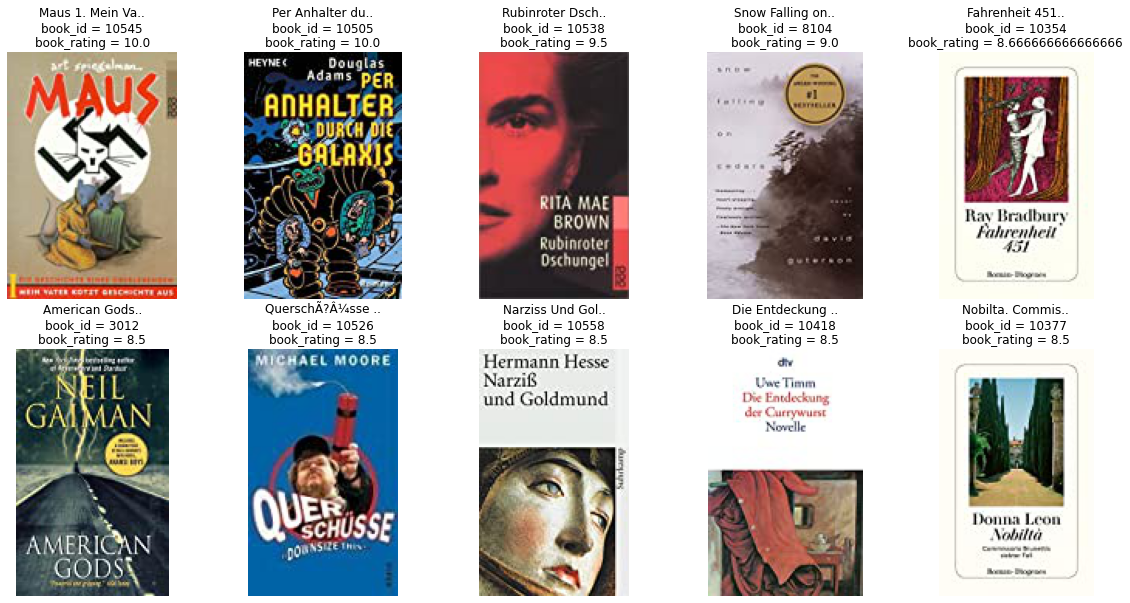

In [23]:
nearNeighb = NearestNeighbors(n_neighbors=180).fit(prep_users_csr)
ind = nearNeighb.kneighbors([prep_users_csr.iloc[3]], return_distance=False);
ratings = np.zeros(csr_rates.shape[1])
count = np.zeros(csr_rates.shape[1]) 

#Определяем средний рейтинг
for i in ind[0]:
    ratings += csr_rates.getrow(i).toarray()[0]
    count[csr_rates.getrow(i).toarray()[0] != 0] += 1

#Если книга была оценена меньше 2-ух раз
count[count < 2] = -1
ratings = ratings / count
print_top_books(np.flip(np.sort(ratings)), np.flip(np.argsort(ratings)), interactions)

In [24]:
del nearNeighb

#### 3. Применить методы расмотренные на лекции (Совстречаемость - 2 балл, Content-based - 1 балл, Коллаборативная фильтрация - 3 балла , Матричная Факторизация - 1 балл) - 7 баллов

In [25]:
class Recomendations():

    def __init__(self, Int):
        self.product_id_to_url = {}
        for i in Int[["product_id", "picture_url"]].drop_duplicates().values:
            self.product_id_to_url[i[0]] = i[1]
        self.interactions = Int
        
    def coocurrency_count(self):

        Int = self.interactions[["vid", "product_id", "Book-Rating"]].drop_duplicates()
        vid_product_id = Int.groupby(["vid"])["product_id"].apply(list).reset_index()
        vid_Book_Rating = Int.groupby(["vid"])["Book-Rating"].apply(list).reset_index()['Book-Rating']
        user_products = pd.concat([vid_product_id, vid_product_id])
        product_num = [len(i) for i in user_products["product_id"]]
        user_products["prod_num"] = product_num
        user_products = user_products[user_products["prod_num"] > 1]
        cooc = {}
        for i in tqdm.tqdm_notebook(user_products.values):
            for j in range(len(i[1])):
                for k in range(len(i[1])):
                    if j != k:
                        try:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] += (i[1][j] + i[1][k]) / 2
                        except:
                            cooc[str(i[1][j]) + "_" + str(i[1][k])] = 1
        cooc_list = []
        for i, j in cooc.items():
            if j != 1:
                cooc_list.append(i.split("_") + [j])

        self.cooc_rec = pd.DataFrame(cooc_list, columns=["item1", "item2", "measure"])
        print(self.cooc_rec)
    
    def get_rec(self, i, show=False):
        recs = self.cooc_rec[self.cooc_rec["item1"] == str(i)]\
                            .sort_values("measure", ascending=False)\
                            .head(10)
        print(u"Для товара")
        rec_imaging([i], self.product_id_to_url)
        print(u"Такие рекомендации")
        rec_imaging(recs["item2"].values.astype(int), self.product_id_to_url, 
                         recs["measure"].values.astype(int))

In [26]:
cooc_rec = Recomendations(interactions)
cooc_rec.coocurrency_count()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/20024 [00:00<?, ?it/s]

        item1 item2  measure
0        5415  5105   5261.0
1        5415  1386   3401.5
2        5415  1393   3405.0
3        5415  1710   3563.5
4        5105  5415   5261.0
...       ...   ...      ...
2562945  4214  9663   6939.5
2562946  6880  2647   4764.5
2562947  2647  6880   4764.5
2562948  2647  4019   3334.0
2562949  4019  2647   3334.0

[2562950 rows x 3 columns]


Для товара


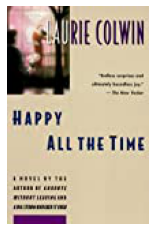

Такие рекомендации


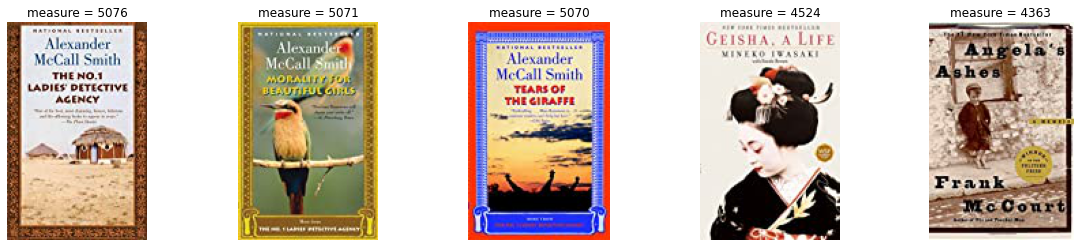

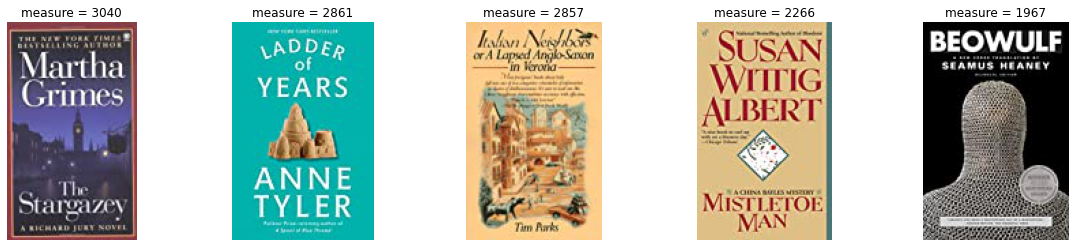

In [27]:
cooc_rec.get_rec(401)

In [28]:
books_text_url = books['Image-URL-M'].copy().to_frame()
books_text_url['text'] = books['Book-Title'] + ' ' + books['Book-Author'] + ' ' + books['Publisher']
books_text_url = books_text_url.rename(columns={"Image-URL-M": "picture_url"})
books_text_url = books_text_url.fillna('')
interactions_text = interactions.copy()
interactions_text = interactions_text.merge(books_text_url, on=['picture_url'])

In [29]:
books_text_url.head()

picture_url                                               text
0  http://images.amazon.com/images/P/0195153448.0...  Classical Mythology Mark P. O. Morford Oxford ...
1  http://images.amazon.com/images/P/0002005018.0...  Clara Callan Richard Bruce Wright HarperFlamin...
2  http://images.amazon.com/images/P/0060973129.0...  Decision in Normandy Carlo D'Este HarperPerennial
3  http://images.amazon.com/images/P/0374157065.0...  Flu: The Story of the Great Influenza Pandemic...
4  http://images.amazon.com/images/P/0393045218.0...  The Mummies of Urumchi E. J. W. Barber W. W. N...

In [30]:
interactions_text.head()

User-ID  ...                                               text
0    86583  ...  Das Lacheln der Fortuna: Historischer Roman Re...
1   132500  ...  Das Lacheln der Fortuna: Historischer Roman Re...
2    66483  ...  Das Lacheln der Fortuna: Historischer Roman Re...
3   276866  ...  Das Lacheln der Fortuna: Historischer Roman Re...
4   106534  ...  Das Lacheln der Fortuna: Historischer Roman Re...

[5 rows x 10 columns]

In [31]:
class Content_Based():
    def __init__(self, items, interactions):
        self.items = items
        self.interactions = interactions
        self.content_dict = {}
        for i, j in enumerate(items["picture_url"]):
            self.content_dict[i] = j
        self.inversed_dict = {v: k for k, v in self.content_dict.items()}
        
    def avg_feature_vector(self, words, model, num_features, index2word_set):
        feature_vec = np.zeros((num_features, ), dtype='float32')
        n_words = 0
        for word in words:
            if word in index2word_set:
                n_words += 1
                feature_vec = np.add(feature_vec, model.wv[word])
        if (n_words > 0):
            feature_vec = feature_vec / n_words
        return feature_vec

    def get_items_representation(self):
        
        item_description = [gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", i.lower())) 
                            for i in self.items['text']]
        #build vocabulary and train model
        self.model = gensim.models.Word2Vec(
                item_description,
                size=200,
                window=10,
                min_count=1,
                workers=10,
                iter=100)
        self.index2word_set = set(self.model.wv.index2word)
        self.items_embs = np.zeros((len(item_description), 200))
        for i in tqdm.notebook.tqdm(range(self.items_embs.shape[0])):
            self.items_embs[i] = self.avg_feature_vector(item_description[i], self.model, 200, self.index2word_set)
        
        
    def get_rec_I2I(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])


    def get_rec_U2I(self, i):
        ui = self.interactions[self.interactions["vid"] == i]
        user_vector = " ".join(ui["text"])
        user_processed = gensim.utils.simple_preprocess(re.sub("[^a-zA-Zа-яА-Я]+", " ", user_vector.lower()))
        user_emb = self.avg_feature_vector(user_processed, self.model, 200, self.index2word_set)
        metrics = cosine_similarity([user_emb], self.items_embs)
        print(u"Для пользователя, который взаимодействовал с товарами")
        rec_imaging(np.unique([self.inversed_dict[i] for i in ui["picture_url"]]), self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(metrics)[0][::-1][1:11], self.content_dict, np.sort(metrics)[0][::-1][1:11])

In [33]:
symbols = "!#$%&'()*+,-./:;<=>?@[\\]^_`{|}~«'»•—®❗️"
def del_symbols(text):
    return text.translate(str.maketrans(symbols, ' ' * len(symbols)))
books_text_url['text'] = books_text_url['text'].apply(lambda text : ' '.join(del_symbols(text).split()))

In [34]:
CB = Content_Based(books_text_url, interactions_text)

In [35]:
CB.get_items_representation()

  0%|          | 0/271360 [00:00<?, ?it/s]

Для товара


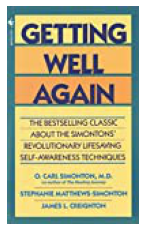

Такие рекомендации


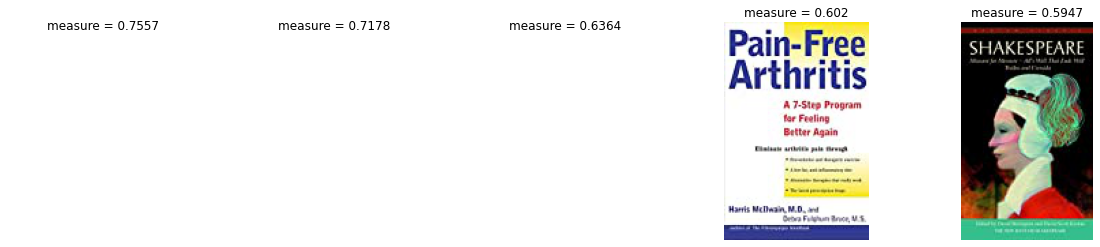

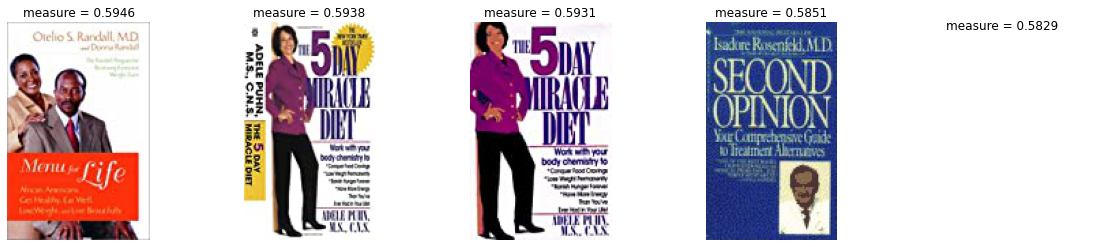

In [36]:
CB.get_rec_I2I(57)

Для пользователя, который взаимодействовал с товарами


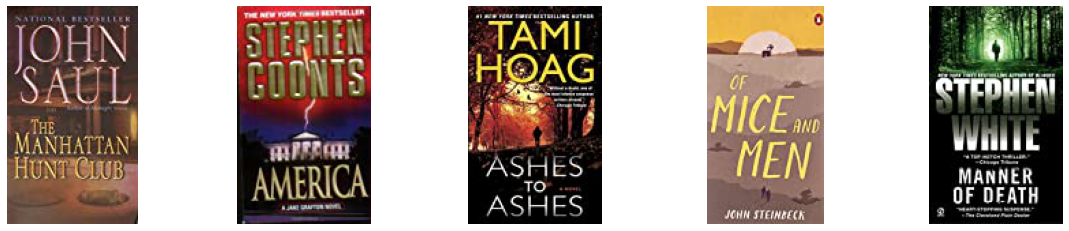

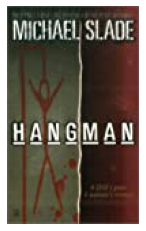

Такие рекомендации


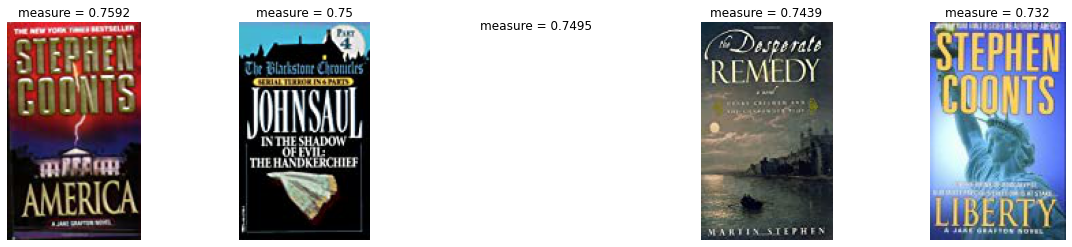

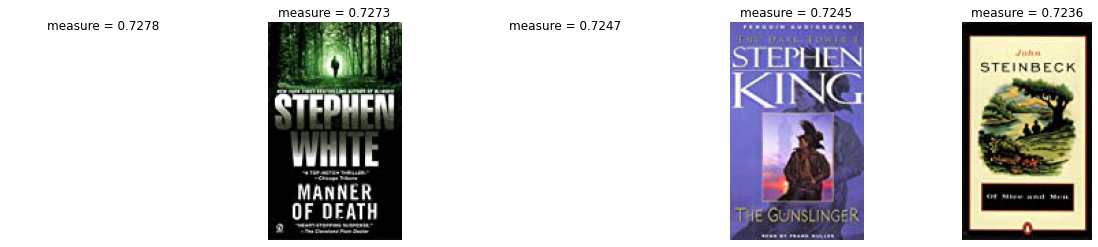

In [37]:
CB.get_rec_U2I(853)

In [38]:
del CB

In [39]:
from sklearn.metrics import pairwise_distances, pairwise_kernels

class Colloborative():
    def __init__(self, interactions, csr_rates):
        self.content_dict = {}
        for i in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i[0]] = i[1]        
        self.csr_rates = csr_rates

    def user_based(self, idx):
        rates = self.csr_rates.copy().toarray().astype(np.float32)
        rates[rates == 0] = None
        user_rates_mean = np.nanmean(rates[idx]), 
        new_rates = rates - np.nanmean(rates, axis=1).reshape(-1, 1)       
        user_rates, new_rates, rates_matrix = np.nan_to_num(rates[idx]), np.nan_to_num(new_rates), np.nan_to_num(rates)
        watched_items = np.where(user_rates != 0)[0]
        metrics = cosine_similarity([user_rates], self.csr_rates).reshape(-1, 1)
        metrics_sum = np.sum(metrics)

        rates = new_rates * metrics
        total_rate = (1 - user_rates.astype(bool))*(user_rates_mean +np.sum(rates, axis=0) / metrics_sum)
        self.get_rec(watched_items, np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10])

    def item_based(self, idx):
        rates_matrix = self.csr_rates.copy().toarray().astype(float)
        rates_matrix[rates_matrix==0] = np.nan        
        item_rates = rates_matrix[:, idx]
        item_rates_mean = np.nanmean(item_rates)
        all_items_rate_mean = np.nanmean(rates_matrix, axis=0)
        new_rates = rates_matrix        
        item_rates = np.nan_to_num(item_rates)
        new_rates = np.nan_to_num(new_rates)
        rates_matrix = np.nan_to_num(rates_matrix)
        item_rates = self.csr_rates.getcol(idx).toarray().reshape(1, -1)
        metrics = cosine_similarity(item_rates, self.csr_rates.T).reshape(-1, 1)
        rates = csr_matrix.multiply(self.csr_rates.T.copy(), metrics)
        total_rate = np.array(np.sum(rates, axis=1)).ravel()
        self.get_rec([idx], np.arange(self.csr_rates.shape[1])[np.argsort(total_rate)[::-1][:10]],
                    np.sort(total_rate)[::-1][:10]) 
        
    def get_rec(self, watched, recs, measure):
        print(u"Для таких товаров")
        rec_imaging([i for i in watched], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging([i for i in recs], self.content_dict, measure)

In [40]:
clb = Colloborative(interactions, csr_rates)

Для таких товаров


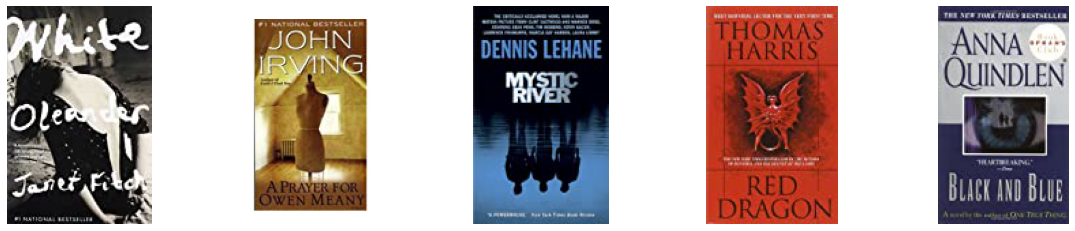

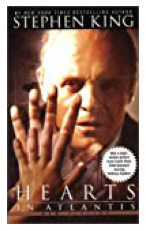

Такие рекомендации


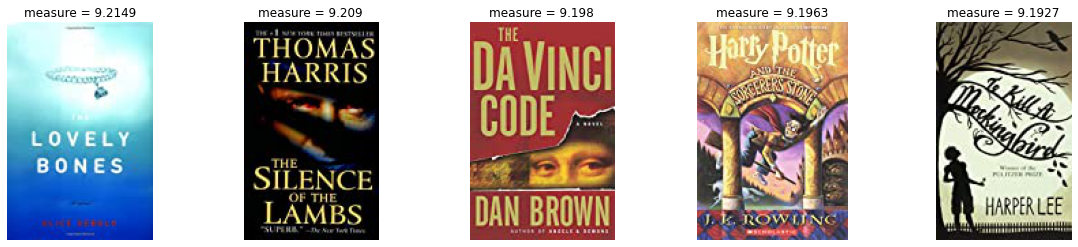

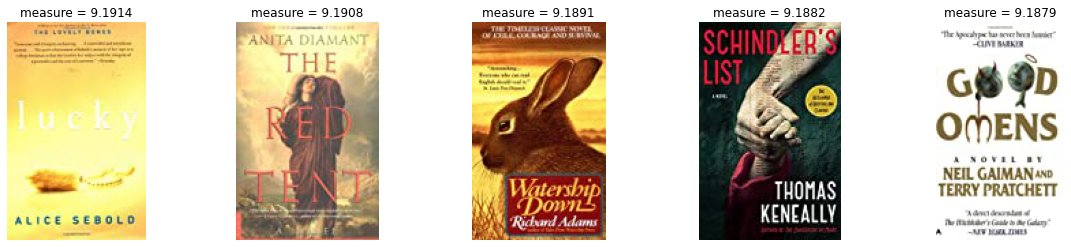

In [41]:
clb.user_based(435)

Для таких товаров


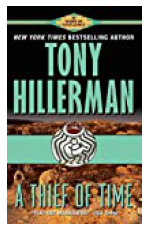

Такие рекомендации


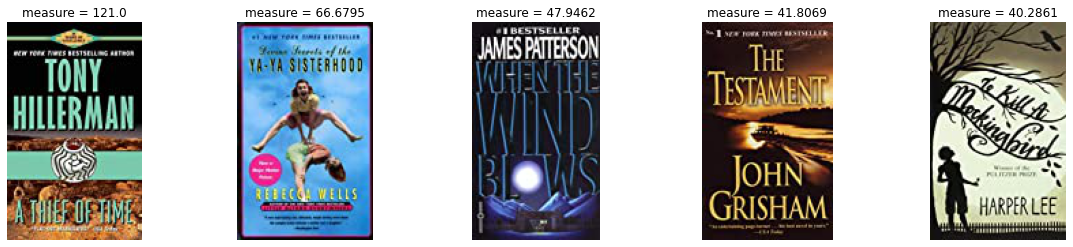

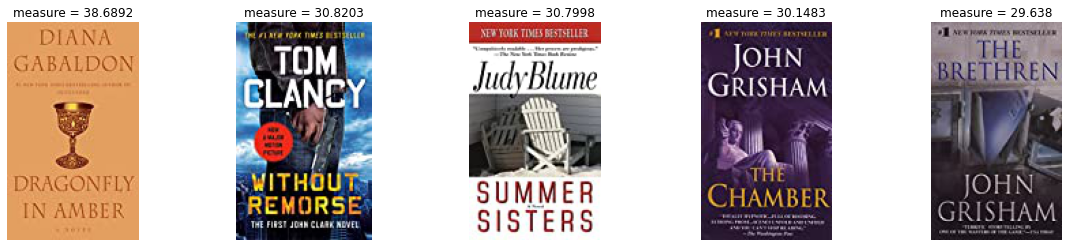

In [42]:
clb.item_based(435)

In [43]:
del clb

######Матричная факторизация

In [44]:
class MatrixFactorization():
    
    def __init__(self, interactions, csr_matrix, k):
        interactions["product_id"] = interactions["product_id"].astype(int)
        self.k = k
        self.content_dict = {}
        for i, j in interactions[["product_id", "picture_url"]].drop_duplicates().values:
            self.content_dict[i] = j
        self.csr_rates = csr_matrix
        
    def MF(self):
        U, S, V = svds(self.csr_rates.astype(float), k=self.k)
        self.user_embs = U
        self.items_embs = V.T
        
    def LightFM(self):
        self.model = LightFM(loss='warp', no_components=100, learning_rate=0.03, learning_schedule="adadelta")
        self.model.fit(self.csr_rates, epochs=5, num_threads=40, verbose=True)
        self.user_feature_bias, self.user_feature_embeddings = self.model.get_user_representations()
        self.item_feature_bias, self.items_embs = self.model.get_item_representations()

    def get_rec(self, i):
        metrics = cosine_similarity([self.items_embs[i]], self.items_embs)
        print(u"Для товара")
        rec_imaging([i], self.content_dict)
        print(u"Такие рекомендации")
        rec_imaging(np.argsort(-metrics)[0][1:11], self.content_dict, -np.round(np.sort(-metrics)[0][1:11], 4))

In [45]:
simple_svd = MatrixFactorization(interactions, csr_rates, 30)
simple_svd.MF()

Для товара


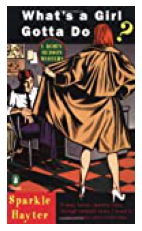

Такие рекомендации


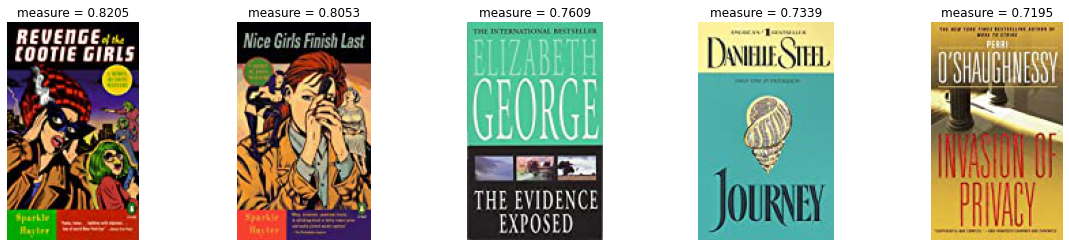

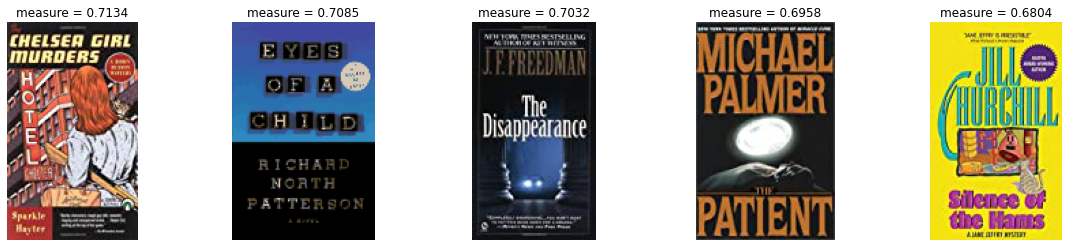

In [46]:
simple_svd.get_rec(935)